# Stream Metrics Analysis Notebook

## Overview
This notebook analyzes stream morphology characteristics including channel width, depth, sinuosity, and bank conditions using digital terrain models (DTM) and GRASS GIS tools. The analysis generates cross-sectional profiles, computes stream metrics, and creates interactive visualizations to assess meadow stream conditions.

## Methodology
The workflow includes:
1. **Data Preparation**: Loading DTM data and setting up GRASS GIS environment
2. **Stream Delineation**: Extracting stream networks from elevation data
3. **Channel Analysis**: Computing main channel characteristics and sinuosity
4. **Bank Assessment**: Analyzing bank height and stability metrics
5. **Cross-Section Generation**: Creating transects perpendicular to the stream
6. **Interactive Visualization**: Generating maps with detailed stream metrics

## Data Requirements
- Digital Terrain Model (DTM) in GeoTIFF format
- Meadow extent polygon (optional, for region definition)
- GRASS GIS with required extensions

## Output Products
- Interactive map with stream metrics and cross-sectional profiles
- Bank height classifications (0-2 ft, 2-4 ft, 4+ ft categories)
- Width-to-depth ratios for habitat assessment
- Sinuosity measurements for channel stability analysis

---

## Library Imports
Import all required Python libraries for geospatial analysis, visualization, and data processing.

In [ ]:
# Interactive mapping and visualization libraries
from folium.plugins import MeasureControl, FloatImage
import ipywidgets
import ipyleaflet

# System and subprocess management
import subprocess
import sys
import os
import io

# Geospatial data handling and analysis
import geopandas as gpd
import pandas as pd
import shapely
import pyproj

# Data visualization and plotting
import altair as alt
import folium
import branca

# Numerical computing and utilities
import numpy as np
import base64
import math
import json
import copy

## GRASS GIS Extensions (Optional)
These extensions can be installed if additional functionality is needed. Currently commented out as they're not required for the basic analysis.

In [ ]:
# GRASS GIS extensions for advanced hydrological analysis
# Uncomment and run these commands if the extensions are not already installed:

# gs.run_command("g.extension", extension="r.accumulate")    # Flow accumulation calculations
# gs.run_command("g.extension", extension="r.profile")      # Elevation profiling along lines
# gs.run_command("g.extension", extension="v.geomorphon")   # Landform classification
# gs.run_command("g.extension", extension="v.centerline")   # Channel centerline extraction

## Version Information
Check versions of key libraries to ensure compatibility.

In [ ]:
# Display version information for key libraries
print(f"ipywidgets version: {ipywidgets.__version__}")      # Interactive widgets for Jupyter
print(f"ipyleaflet version: {ipyleaflet.__version__}")      # Interactive maps for Jupyter
print(f"folium version: {folium.__version__}")              # Web mapping library
# print(f"GDAL version: {gdal.__version__}")                # Geospatial data abstraction library
print(f"python version:{sys.version[:6]}")                  # Python interpreter version

ipywidgets version: 8.1.7
ipyleaflet version: 0.20.0
folium version: 0.20.0
python version:3.11.1


## Configuration
Set the study site name - this should match your data folder name.

In [ ]:
# Study site identifier - change this to match your data folder
# Expected folder structure: ../data/{name}/
name = "Lacey"

## GRASS GIS Setup
Initialize GRASS GIS environment and import the necessary modules.

In [ ]:
# Configure Python environment for GRASS GIS integration
import subprocess
import sys

# Dynamically add GRASS GIS Python packages to the system path
# This ensures compatibility across different GRASS installations
sys.path.append(
    subprocess.check_output(["grass", "--config", "python_path"], text=True).strip()
)

# Import GRASS GIS Python API modules
import grass.script as gs        # Core GRASS scripting interface
import grass.jupyter as gj       # Jupyter notebook integration tools

## Workspace Setup
Navigate to the data directory and prepare the workspace for analysis.

In [ ]:
# Navigate to the study site data directory
# This directory should contain the DTM file and any other spatial data
os.chdir(f"../data/{name}")
print(f"Current working directory: {os.getcwd()}")

'/media/grendel/7db216a7-836f-4e8d-b439-e4f999cedb23/USGS/meadow_assessment/data/Lacey'

In [ ]:
import shutil
from pathlib import Path

# Clean up any existing temporary GRASS location to ensure a fresh start
# This prevents conflicts from previous analysis runs
dirpath = Path('temp_location')
if dirpath.exists() and dirpath.is_dir():
    print("Removing existing temp_location directory...")
    shutil.rmtree(dirpath)
else:
    print("No existing temp_location found.")

## GRASS Location Initialization
Create a new GRASS location based on the DTM projection and start a GRASS session.

In [ ]:
# Create a new GRASS GIS location using the DTM's coordinate reference system
# The -c flag creates a location from a georeferenced file
# The -e flag exits after creation without starting an interactive session
!grass -c dtm_{name}.tif -e temp_location

Creating new GRASS GIS project <temp_location>...


In [ ]:
# Initialize GRASS session for Jupyter notebook integration
# This enables interactive mapping and GRASS command execution
session = gj.init("temp_location")

## Digital Terrain Model (DTM) Processing
Import the elevation data and create visualization products including relief shading.

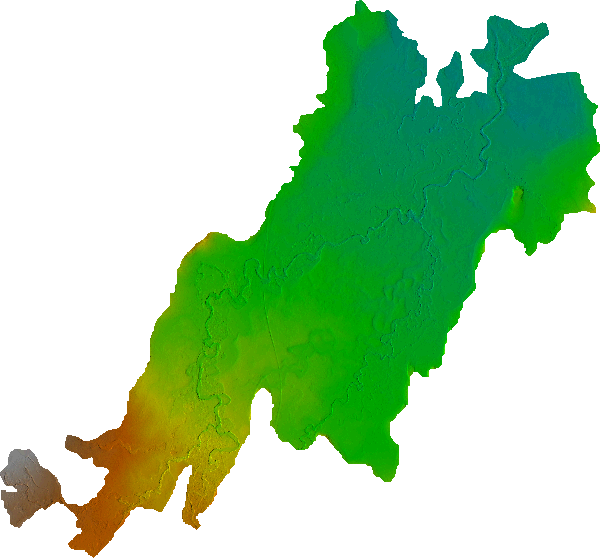

In [ ]:
# Import the DTM as an external raster (linked, not copied)
gs.run_command("r.external", input=f"dtm_{name}.tif", output="dtm")

# Apply standard elevation color scheme (blue=low, green=mid, brown/white=high)
gs.run_command("r.colors", map="dtm", color="elevation")

# Generate relief shading for terrain visualization
gs.run_command("r.relief", input="dtm", output="dtm_relief")

# Combine elevation colors with relief shading for enhanced visualization
gs.run_command("r.shade", shade="dtm_relief", color="dtm", output="dtm_shade")

# Display the shaded relief map
map = gj.Map()
map.d_rast(map='dtm_shade')
map.show()

## Stream Network Extraction
Extract stream networks from the DTM using hydrological modeling techniques.

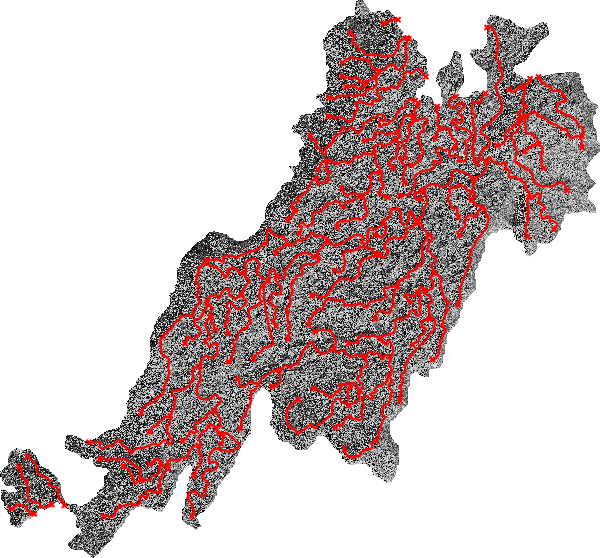

In [ ]:
# Extract stream networks using topographic analysis
# threshold=500: minimum flow accumulation for stream initiation
# mexp=0.5: exponent for slope-area relationship  
# stream_length=500: minimum stream segment length in meters
gs.run_command("r.stream.extract", elevation="dtm", threshold=500,
                mexp=0.5, stream_length=500, memory=100000, 
                stream_raster="stream_r",      # Output: stream raster
                direction="direction_r",       # Output: flow direction
                stream_vector="stream_vect")   # Output: stream vectors

# Visualize flow directions and extracted streams
map = gj.Map()
map.d_rast(map='direction_r')                           # Flow direction (8-direction)
map.d_vect(map='stream_vect', color="red", width=2)     # Extracted streams in red
map.show()

## Stream Ordering and Main Channel Identification
Apply stream ordering algorithms and identify the main channel using Hack's Law.

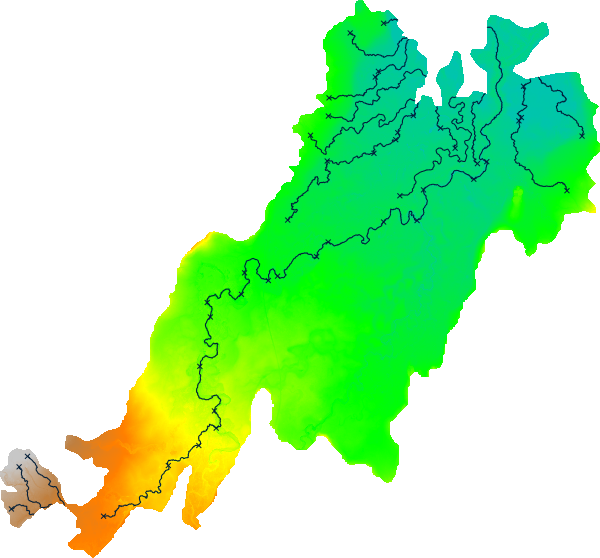

In [ ]:
# Calculate flow accumulation for the watershed
# This determines drainage area contributing to each cell
gs.run_command("r.accumulate", direction="direction_r", format="auto", 
               accumulation="accum", outlet="stream_vect", 
               longest_flow_path="longest_stream")

# Apply stream ordering using Hack's Law methodology
# Hack ordering identifies main channels vs. tributaries based on length-area relationships
gs.run_command("r.stream.order", stream_rast="stream_r", accumulation="accum", 
                direction="direction_r", elevation="dtm", 
                hack="stream_hack",      # Hack ordering output
                stream_vect="stream_v")  # Updated stream vectors with ordering

# Extract main channel segments (Hack order = 1 represents main channels)
gs.run_command("v.extract", input="stream_v", where='"hack" = 1', 
               output="hack_1_channels")

# Connect main channel segments into continuous polylines
gs.run_command("v.build.polylines", input="hack_1_channels", 
               output="connected_channels", cats="first")

# Display the main channel network
map = gj.Map()
map.d_rast(map='dtm')                    # Base elevation
map.d_vect(map='connected_channels')     # Connected main channels
map.show()

## Longest Channel Analysis
Identify the longest channel segment and calculate sinuosity metrics.

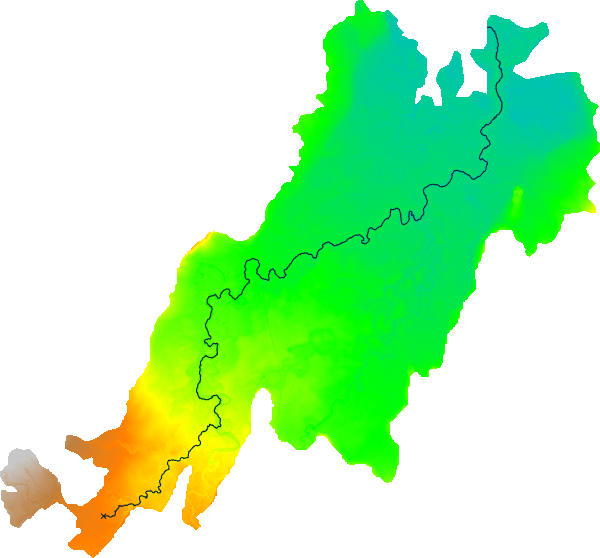

In [ ]:
# Identify the longest channel segment for detailed analysis
# Calculate lengths of all connected channel segments
lengths = gs.read_command("v.to.db", flags="p", map="connected_channels", 
                         type="line", option="length", columns="aa", separator=",")

# Parse the length data and find the segment with maximum length
df = pd.read_csv(io.StringIO(lengths))
cat = df.iloc[df['length'].idxmax(), 0]  # Get category ID of longest segment

# Extract the longest channel segment
gs.run_command("v.extract", input="connected_channels", 
               output="longest_channel", cat=cat)

# Visualize the longest channel
map = gj.Map()
map.d_rast(map='dtm')           # Base terrain
map.d_vect(map='longest_channel') # Longest channel highlighted
map.show()

In [ ]:
# Simplify the channel geometry using the snakes algorithm
# This reduces vertex density while preserving overall channel form
gs.run_command("v.generalize", input="longest_channel", type="line", 
               method="snakes", threshold=1, 
               output="longest_channel_simplified")

# Export the simplified main channel for external use
gs.run_command("v.out.ogr", input="longest_channel_simplified", 
               output=f"{name}_main_channel.geojson", format="GeoJSON")

# Calculate sinuosity (ratio of channel length to straight-line distance)
# Sinuosity > 1.5 indicates a meandering channel
t = !v.to.db map=longest_channel_simplified option=sinuous columns=sinuosity -p

# Extract sinuosity value from the output
sino = t[3].split("|")[1]
print(f"Channel sinuosity: {sino}")
sino

'1.81917670968402'

## Bank Analysis and Height Above Nearest Drainage (HAND)
Calculate Height Above Nearest Drainage (HAND) and perform least-cost path analysis to identify stream banks.

In [ ]:
# Step 1: Create buffer around the main channel for focused analysis
gs.run_command("v.buffer", input="longest_channel_simplified", 
               output="channel_buffer", type="line", distance=15)

# Step 2: Apply mask to limit HAND calculation to channel buffer area
gs.run_command("r.mask", vector="channel_buffer")

# Step 3: Calculate Height Above Nearest Drainage (HAND)
# HAND measures vertical distance from each point to the nearest stream
# Lower values indicate proximity to water level (potential wetted area)
gs.run_command("r.stream.distance", stream_rast="stream_r", 
               direction="direction_r", elevation="dtm", difference="hand")

# Step 4: Remove mask to allow full-extent calculations
gs.run_command("r.mask", flags="r")

# Step 5: Apply blue-cyan-yellow-red color scheme to HAND values
# Blue = low (near stream level), Red = high (elevated banks)
gs.run_command("r.colors", map="hand", color="bcyr")

# Step 6: Calculate maximum curvature for terrain complexity analysis
# High curvature values indicate steep terrain or channel features
gs.run_command("r.param.scale", input="dtm", output="maxcurvature", 
               size=7, method="maxic")

# Step 7: Reapply mask for cost surface calculations
gs.run_command("r.mask", vector="channel_buffer")

# Step 8: Convert channel vector to raster for cost analysis
gs.run_command("v.to.rast", type="line", input="longest_channel_simplified", 
               output="longest_channel_simplified", use="val", flags="d")

# Step 9: Create high-cost barriers at channel endpoints
# This prevents bank lines from routing around channel ends
high_cost = 100000
gs.run_command("v.to.points", input="longest_channel_simplified", 
               output="longest_channel_simplified_start", use="start")
gs.run_command("v.to.points", input="longest_channel_simplified", 
               output="longest_channel_simplified_end", use="end")
gs.run_command("v.patch", input="longest_channel_simplified_start,longest_channel_simplified_end", 
               output="longest_channel_simplified_start_end")
gs.run_command("v.to.rast", input="longest_channel_simplified_start_end", 
               output="longest_channel_simplified_start_end", type="point", 
               use="val", value=high_cost)
gs.run_command("r.grow", flags="m", input="longest_channel_simplified_start_end", 
               output="longest_channel_simplified_start_end_buffer", radius=10)

# Step 10: Create cost surface based on terrain curvature
# Lower costs for smooth terrain, higher costs for complex topography
baseline_cost = 100
curvature_threshold = 0.95
gs.mapcalc(f"cost = if ( isnull(longest_channel_simplified), if ((1 - maxcurvature) < {curvature_threshold}, 1 - maxcurvature, {baseline_cost}), {high_cost})")
gs.run_command("r.patch", input=["longest_channel_simplified_start_end_buffer", "cost"], output="cost")

# Step 11: Create starting points for bank analysis on both sides of channel
category = gs.read_command("v.category", input="longest_channel_simplified", 
                          type="line", option="print").strip()
offset = 20        # Distance from channel endpoints (meters)
side_offset = 5    # Perpendicular offset from channel centerline (meters)

# Generate starting points offset from channel endpoints
gs.write_command("v.segment", input="longest_channel_simplified", 
                output="start_point_right", rules="-", 
                stdin=f"P 1 {category} {offset} {side_offset}")
gs.write_command("v.segment", input="longest_channel_simplified", 
                output="start_point_left", rules="-", 
                stdin=f"P 1 {category} {offset} -{side_offset}")
gs.write_command("v.segment", input="longest_channel_simplified", 
                output="end_point_right", rules="-", 
                stdin=f"P 1 {category} -{offset} {side_offset}")
gs.write_command("v.segment", input="longest_channel_simplified", 
                output="end_point_left", rules="-", 
                stdin=f"P 1 {category} -{offset} -{side_offset}")

# Step 12: Calculate cumulative cost surfaces from starting points
gs.run_command("r.cost", flags="k", input="cost", 
               output="cumulative_cost_right", outdir="costdir_right", 
               start_points="start_point_right")
gs.run_command("r.cost", flags="k", input="cost", 
               output="cumulative_cost_left", outdir="costdir_left", 
               start_points="start_point_left")

# Step 13: Generate least-cost paths (bank lines) and extract HAND values
gs.run_command("r.path", flags="c", input="costdir_right", 
               vector_path="bank_right", raster_path="bank_right", 
               values="hand", start_points="end_point_right")
gs.run_command("r.path", flags="c", input="costdir_left", 
               vector_path="bank_left", raster_path="bank_left", 
               values="hand", start_points="end_point_left")

# Step 14: Reclassify bank heights into American Rivers categories
# 0-0.6m (0-2 ft), 0.6-1.2m (2-4 ft), 1.2m+ (4+ ft)
gs.write_command("r.recode", input="bank_right", output="bank_recode_right", 
                 rules="-", stdin="\n".join(["0:0.6:1", "0.6:1.2:2", "1.2:3:3"]))
gs.write_command("r.recode", input="bank_left", output="bank_recode_left", 
                 rules="-", stdin="\n".join(["0:0.6:1", "0.6:1.2:2", "1.2:3:3"]))

# Step 15: Generate channel centerline from bank boundaries
# Combine left and right banks into a single vector
gs.run_command("v.patch", input=["bank_left", "bank_right"], output="banks")

# Clean up vector categories for proper centerline calculation
gs.run_command("v.category", input="banks", output="banks2", option="del")
gs.run_command("v.category", input="banks2", output="banks", option="add")

# Calculate optimal vertex spacing for centerline (every 2 meters)
lengths = gs.read_command("v.report", map="banks", option="length", 
                         flags="c", separator="comma", units="meters").splitlines()
num_vertices = round(float(lengths[0].split(",")[1]) / 2)

# Generate centerline between the banks
gs.run_command("v.centerline", input="banks", output="banks_center2", 
               vertices=num_vertices)
gs.run_command("v.category", input="banks_center2", output="banks_center", 
               option="add")

# Display interactive map showing channel analysis results
map = gj.InteractiveMap(height=700, width=900)
map.add_raster(name='dtm_shade')              # Terrain background
map.add_vector(name='longest_channel_simplified')  # Original channel
map.add_vector(name='bank_right')             # Right bank line
map.add_vector(name='banks_center')           # Calculated centerline
map.add_vector(name='bank_left')              # Left bank line
map.add_layer_control()
map.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Bank Height Statistics
Calculate and analyze bank height distributions using American Rivers categories.

In [ ]:
# Combine left and right bank classifications
gs.run_command("r.patch", input="bank_recode_right,bank_recode_left", 
               output="banks_recode")

# Generate statistics for each bank and combined analysis
stats_right = gs.read_command("r.stats", input="bank_recode_right", 
                             flags="na", separator="comma")
stats_left = gs.read_command("r.stats", input="bank_recode_left", 
                            flags="na", separator="comma")
stats_both = gs.read_command("r.stats", input="banks_recode", 
                            flags="na", separator="comma")

# Remove any active masks
gs.run_command("r.mask", flags="r")

# Process bank height statistics into a formatted dataframe
df_b = pd.read_csv(io.StringIO(stats_right), names=["category", "area"], index_col=0)
df_b["bank"] = ["0-2 feet", "2-4 feet", "4+ feet"]  # American Rivers categories
df_b["percentage"] = df_b.area/df_b.area.sum() * 100
print("Bank Height Distribution (Right Bank):")
df_b

,area,bank,percentage
category,,,
1,279.36,0-2 feet,18.042316
2,1057.68,2-4 feet,68.309695
3,211.32,4+ feet,13.647989


In [ ]:
# Generate geomorphon landform classification before using it
# search=10: analysis window radius (10 cells)
# skip=3: skip cells for faster processing  
# flat=2.5: flatness threshold (degrees)
gs.run_command("r.geomorphon", forms="forms", elevation="dtm", 
               search=10, skip=3, flat=2.5)

# Calculate bank height statistics within hollow landforms only
# Geomorphon category 4 = hollows (valley bottoms and depressions)
# This focuses analysis on the most hydrologically relevant areas

# Apply mask to analyze only hollow landform areas
gs.run_command("r.mask", raster="forms", maskcats=4)

# Reclassify HAND values using American Rivers bank height categories
gs.write_command("r.recode", input="hand", output="hand_recode", rules="-", 
                 stdin="\n".join(["0:0.6:1", "0.6:1.2:2", "1.2:3:3"]))

# Generate statistics for hollow areas only
stats = gs.read_command("r.stats", input="hand_recode", flags="na", separator="comma")
gs.run_command("r.mask", flags="r")

# Format results into dataframe
df_h = pd.read_csv(io.StringIO(stats), names=["category", "area"], index_col=0)
df_h["bank"] = ["0-2 feet", "2-4 feet", "4+ feet"]
df_h["percentage"] = df_h.area/df_h.area.sum() * 100
print("Bank Height Distribution (Hollow Landforms Only):")
df_h

,area,bank,percentage
category,,,
1,2714.04,0-2 feet,14.910407
2,11062.80,2-4 feet,60.776868
3,4425.48,4+ feet,24.312725


## Cross-Sectional Analysis Setup
Create transects perpendicular to the channel centerline for detailed cross-sectional analysis.

In [ ]:
# Calculate distance to stream for additional analysis
gs.run_command("r.stream.distance", stream_rast="stream_r", 
               direction="direction_r", elevation="dtm", difference="stream")

# Generate transects perpendicular to the channel centerline
# dleft/dright=10: extend 10m on each side of centerline
# transect_spacing=10: create transects every 10 meters along channel
gs.run_command("v.transects", input="banks_center", output="transects", 
               dleft=10, dright=10, transect_spacing=10, 
               transect_perpendicular="trend", metric="along")

# Convert transects to point vertices for coordinate extraction
gs.run_command("v.to.points", input="transects", out="points", use="vertex")

# Extract coordinates and organize by transect category
result = gs.read_command("v.out.ascii", input="points", separator=",")
df_t = pd.DataFrame([row.rsplit(',',1) for row in result.splitlines()],
                    columns=["coors","cat"])
df_t = df_t.groupby('cat')['coors'].apply(','.join).reset_index()
df_t = df_t.astype({'cat':int}).sort_values(by=['cat'], ignore_index=True)

print(f"Generated {len(df_t)} transects for analysis")
df_t.head()

,cat,coors
0,1,"722462.86764958,4373397.22456732,722448.725513..."
1,2,"722470.62104855,4373389.39787344,722455.114250..."
2,3,"722476.46309984,4373380.57356832,722460.077300..."
3,4,"722482.88384307,4373371.84973363,722465.522041..."
4,5,"722487.49693135,4373361.01750452,722468.604090..."


## Stream Metrics Calculation Function
Define function to analyze cross-sectional profiles and extract stream channel dimensions.

In [ ]:
def stream_metrics(df):
    """
    Analyze cross-sectional profile to extract stream channel metrics.
    
    Uses slope analysis to identify bankfull width and depth:
    - Toe: where slope > 7% (start of bank)
    - Shoulder: where slope < 5% after toe (top of bank)
    
    Parameters:
    df: DataFrame with 'distance_(m)' and 'elevation_(m)' columns
    
    Returns:
    tuple: (width, left_distance, right_distance, height, bankfull_elevation, max_slope)
    """
    
    # Calculate slopes along the profile using numerical gradients
    slopes = np.gradient(df['elevation_(m)'])
    curv = np.gradient(slopes)  # Second derivative (curvature)
    
    max_slope = abs(slopes).max()
    
    # Find channel center (thalweg) - assumed to be midpoint of profile
    ctr = int(len(df) / 2)
    thalweg = df['elevation_(m)'][ctr]  # Lowest elevation if no water present
    
    # Initialize variables for bank detection
    toe_rt = 0          # Right bank toe detected flag
    shoulder_rt = 0     # Right bank shoulder detected flag
    toe_lf = 0          # Left bank toe detected flag
    shoulder_lt = 0     # Left bank shoulder detected flag
    
    dist_lf = None      # Distance to left bank
    dist_rt = None      # Distance to right bank
    stream_ht_lf = None # Height of left bank
    stream_ht_rt = None # Height of right bank

    # Analyze right bank (from center moving right)
    for rt in range(ctr, len(df)):
        # Detect toe: slope > 7% indicates start of bank rise
        if slopes[rt] > 0.07:
            toe_rt = 1
        # Detect shoulder: slope < 5% after toe indicates top of bank
        if slopes[rt] < 0.05 and toe_rt == 1:
            shoulder_rt = 1
            dist_rt = rt * 0.6          # Convert index to meters (0.6m spacing)
            bankfull_rt = df['elevation_(m)'][rt]
            stream_ht_rt = bankfull_rt - thalweg 
            break

    # Analyze left bank (from center moving left)
    for lf in range(ctr, 0, -1):
        # Detect toe: negative slope > 7% (downward from bank)
        if slopes[lf] < -0.07:
            toe_lf = 1
        # Detect shoulder: slope > -5% after toe indicates top of bank
        if slopes[lf] > -0.05 and toe_lf == 1:
            shoulder_lf = 1
            dist_lf = lf * 0.6          # Convert index to meters
            bankfull_lf = df['elevation_(m)'][lf]
            stream_ht_lf = bankfull_lf - thalweg 
            break

    # Calculate channel width if both banks detected
    if dist_lf is not None and dist_rt is not None:
        dl = abs(dist_lf) + 0.6      # Adjust left distance
        dr = dist_rt - 0.6           # Adjust right distance  
        stream_w = dr - dl           # Channel width
    else: 
        stream_w = "invalid"
        dl = "invalid"
        dr = "invalid"

    # Calculate average channel depth and bankfull elevation
    if stream_ht_lf is not None and stream_ht_rt is not None:
        stream_ht = (stream_ht_lf + stream_ht_rt) / 2    # Average depth
        bankfull = (bankfull_lf + bankfull_rt) / 2       # Average bankfull elevation
    else:
        stream_ht = "invalid"
        bankfull = "invalid"

    return(stream_w, dl, dr, stream_ht, bankfull, max_slope)
# Initialize variables for analysis results
df_t['color'] = 0           # Color classification for each transect
widths = []                 # Collected channel widths
heights = []                # Collected channel depths  
html = []                   # HTML/JSON for profile charts
fdf = []                    # Profile dataframes for each transect
fdfval = []                 # Detailed metrics values
val = []                    # Summary metrics for each transect

print(f"Processing {len(df_t)} transects for stream metrics...")

for index, row in df_t.iterrows():
    # Generate elevation profile along the transect line
    profile = gs.read_command("r.profile", input="dtm", coordinates=(row["coors"]))
    
    # Parse profile data into a structured dataframe
    profile_df = pd.DataFrame([row.split() for row in profile.splitlines()],
                              columns=["distance_(m)", "elevation_(m)"]).apply(pd.to_numeric, errors='coerce')
    fdf.append(profile_df)
    
    # Extract stream metrics from the profile
    w, dl, dr, h, b, ms = stream_metrics(profile_df)

    # Classify transects based on width-to-depth ratios and channel detectability
    if dl != "invalid" and dr != "invalid":
        heights.append(h)
        widths.append(w)
        
        # Only classify channels with significant depth (>0.5m)
        if h > 0.5:
            # Width-to-depth ratio classification for habitat assessment:
            if w/h < 4:              # Deep, narrow channel
                df_t.loc[index,'color'] = 1
            elif w/h < 5.5:          # Moderate width-to-depth
                df_t.loc[index,'color'] = 2  
            elif w/h < 6.5:          # Wide, shallow channel
                df_t.loc[index,'color'] = 3
        else:
            df_t.loc[index,'color'] = 0    # Shallow/unclear channel
    else: 
        df_t.loc[index,'color'] = 4        # No detectable banks

    # Create interactive elevation profile chart using Altair
    chart = alt.Chart(profile_df).mark_line().encode(
        alt.X('distance_(m)', title='Distance (m)'),
        alt.Y('elevation_(m):Q', title='Elevation (m)',
              scale=alt.Scale(domainMin=profile_df['elevation_(m)'].min() - 1,
                              domainMax=profile_df["elevation_(m)"].max() + 1))
    ).properties(width=650, height=100, title=f'Transect {index+1} Profile')

    # Add bankfull elevation indicator (purple dashed line)
    bankfull_line = alt.Chart(pd.DataFrame({'elevation_(m)': [b]})).mark_rule(
        size=1, strokeWidth=2, strokeCap='butt', 
        strokeDash=[4,4], color='purple'
    ).encode(y='elevation_(m)')
    
    # Add left bank position indicator (red dashed line)
    left_bank = alt.Chart(pd.DataFrame({'distance_(m)': [dl]})).mark_rule(
        size=1, strokeWidth=1, strokeCap='butt',
        strokeDash=[2,2], color='red'
    ).encode(x='distance_(m)')

    # Add right bank position indicator (green dashed line)
    right_bank = alt.Chart(pd.DataFrame({'distance_(m)': [dr]})).mark_rule(
        size=1, strokeWidth=1, strokeCap='butt',
        strokeDash=[2,2], color='green'  
    ).encode(x='distance_(m)')

    # Combine all chart elements (currently just the profile line)
    final_chart = chart
    
    # Convert to dictionary format for Folium integration
    chart_dict = final_chart.to_dict()
    html.append(chart_dict)
    val.append([index, w, dl, dr, h, b, ms])

df_mc = pd.DataFrame(fdf[0])
df_mc.head()

,distance_(m),elevation_(m)
0,0.0,2066.384766
1,0.6,2066.339355
2,1.2,2066.255615
3,1.8,2066.235596
4,2.4,2066.243408


## Summary Statistics
Calculate overall channel width and depth statistics from all analyzed transects.

In [ ]:
# Calculate average channel dimensions across all valid transects
total_width = sum(widths)
avg_width = total_width / len(widths) if len(widths) > 0 else 0
print(f"Average channel width: {avg_width:.2f} meters (n={len(widths)} transects)")

total_height = sum(heights) 
avg_height = total_height / len(heights) if len(heights) > 0 else 0
print(f"Average channel depth: {avg_height:.2f} meters (n={len(heights)} transects)")

# Calculate width-to-depth ratio for habitat assessment
if avg_height > 0:
    w_d_ratio = avg_width / avg_height
    print(f"Average width-to-depth ratio: {w_d_ratio:.2f}")
else:
    print("Unable to calculate width-to-depth ratio (insufficient data)")

8.741721854304636
0.6245545380794676


In [ ]:
# Export transects to GeoJSON format for external GIS analysis
gs.run_command("v.out.ogr", input="transects", output="transects.geojson", format="GeoJSON")
print("Transects exported to 'transects.geojson'")

## Data Preparation for Interactive Mapping
Prepare the transect data for web-based interactive visualization.

In [ ]:
# Prepare transect data for interactive mapping
# Load transects and reproject to WGS84 (EPSG:4326) for web mapping
trnscts = gpd.read_file('transects.geojson').to_crs(4326)

# Add analysis results to the transect geodataframe
trnscts['html'] = html              # Interactive profile charts
trnscts['color'] = df_t['color']    # Color classification based on channel metrics

## Geomorphon Landform Analysis
Generate landform classifications to understand the terrain context of the stream channel.

## Map Extent and Layout Configuration
Set up the map extent and define styling functions for the interactive visualization.

In [ ]:
# Import meadow extent boundary and calculate map center for optimal display
gs.run_command("v.in.ogr", input="meadow_extent.geojson", output="meadow_extent")

# Get geographic extent and center coordinates for map initialization
meadow_extent = gs.parse_command("g.region", vector="meadow_extent", flags="ucgl")
loc = (float(meadow_extent["center_long"]), float(meadow_extent["center_lat"]))
print(f"Map center: {loc[1]:.6f}, {loc[0]:.6f} (lat, lon)")

ERROR: Coordinate reference system of dataset does not appear to match
       current project.

       Project PROJ_INFO is:
       name: NAD83(2011) / UTM zone 10N
       datum: nad83_2011
       ellps: grs80
       proj: utm
       zone: 10
       towgs84: 0,0,0,0,0,0,0
       no_defs: defined

       Dataset PROJ_INFO is:
       name: WGS 84 / UTM zone 10N
       datum: wgs84
       ellps: wgs84
       proj: utm
       zone: 10
       no_defs: defined

       Difference in: ellps, a, es

       In case of no significant differences in the coordinate reference
       system definitions, use the -o flag to ignore them and use current
       project definition.
       Consider generating a new project from the input dataset using the
       'project' parameter.


CalledModuleError: Module run `v.in.ogr input=meadow_extent.geojson output=meadow_extent` ended with an error.
The subprocess ended with a non-zero return code: 1. See errors above the traceback or in the error output.

In [ ]:
def transect_style(color):
    """
    Define styling for transects based on channel classification.
    
    Color codes:
    1 = Red: Deep, narrow channels (W:D < 4)
    2 = Orange: Moderate channels (W:D 4-5.5) 
    3 = Yellow: Wide, shallow channels (W:D 5.5-6.5)
    4 = Grey: No detectable banks
    0 = Purple: Shallow/unclear channels (depth < 0.5m)
    """
    if color == 1:
        style = lambda x: {'color':'red','weight':3,'dashArray':"4,8"}      # Deep, narrow
    elif color == 2:  
        style = lambda x: {'color':'orange','weight':3,'dashArray':"4,8"}   # Moderate
    elif color == 3:
        style = lambda x: {'color':'yellow','weight':3,'dashArray':"4,8"}   # Wide, shallow
    elif color == 4:
        style = lambda x: {'color':'grey','weight':3,'dashArray':"4,8"}     # No banks
    else:  # color == 0
        style = lambda x: {'color':'purple','weight':3,'dashArray':"4,8"}   # Shallow/unclear
    return style

## Final Interactive Map Generation
Create the comprehensive interactive map with all analysis results, including terrain data, stream metrics, and cross-sectional profiles.

In [ ]:
# Initialize the base map centered on the study area
m = folium.Map(location=[loc[1], loc[0]], zoom_start=14, max_zoom=21, 
               tiles="OpenStreetMap")

# Create summary metrics display for the map overlay
map_title = "Stream Metrics"
title_style = "position:absolute;z-index:10000;left:5vw;top:1vw;color:orange;font-size:16px;font-weight:bold"

# Format key metrics for display
metrics1 = f"Sinuosity: {round(float(sino),3)}"
metrics2 = f"Width/Depth: {round((avg_width/avg_height),3)}" if avg_height > 0 else "Width/Depth: N/A"
metrics3 = "Bank Category Distribution:"
metrics4 = f"{df_b.bank.iloc[0]}: {df_b.percentage.iloc[0]:.2f}%"
metrics5 = f"{df_b.bank.iloc[1]}: {df_b.percentage.iloc[1]:.2f}%"
metrics6 = f"{df_b.bank.iloc[2]}: {df_b.percentage.iloc[2]:.2f}%"

# Style and add the metrics overlay to the map
metrics_style = "position:absolute;z-index:9000;left:5vw;top:5vw;color:white;font-size:14px"
title_html = f'<p style={metrics_style}>{metrics1}<br>{metrics2}<br>{metrics3}<br>{metrics4}<br>{metrics5}<br>{metrics6}</p><h1 style={title_style}>{map_title}</h1>'
m.get_root().html.add_child(folium.Element(title_html))

# Add USGS logo to the map (optional - requires USGS.png file)
try:
    image_usgs = "../USGS.png"
    with open(image_usgs, 'rb') as lf:
        # Encode image as base64 for web display
        b64_content = base64.b64encode(lf.read()).decode('utf-8') 
    FloatImage('data:image/png;base64,{}'.format(b64_content), 
               bottom=0, left=0, width='8%', height='7%').add_to(m)
except FileNotFoundError:
    print("USGS.png not found - skipping logo")

# Add raster layers (initially hidden for performance)
gj.Raster('dtm_shade', show=False).add_to(m)                    # Shaded relief
gj.Raster('forms', 'geomorphons', opacity=0.7, show=False).add_to(m)  # Landform classification
gj.Raster('hand', show=False, opacity=0.7).add_to(m)           # Height above drainage
gj.Raster('hand_recode', show=False, opacity=0.7).add_to(m)    # Classified bank heights

# Add vector layers for stream analysis
gj.Vector('longest_channel_simplified', 'main channel').add_to(m)        # Main channel
gj.Vector('bank_right', 'right bank', color='black', opacity=0.5).add_to(m)  # Right bank
gj.Vector('bank_left', 'left bank', color='black', opacity=0.5).add_to(m)    # Left bank

# Create interactive transects layer with elevation profile popups
fg = folium.FeatureGroup(name='Transects').add_to(m)

for _, s in trnscts.iterrows():
    graph = s['html']                    # Elevation profile chart data
    coords = list(s['geometry'].coords)  # Transect line coordinates
    ttip = s['cat']                      # Transect ID for tooltip
    
    # Create GeoJSON geometry for the transect line
    geo_data = {"type": "LineString", "coordinates": coords}
    
    # Add interactive transect with styled line and popup chart
    geo_obj = folium.GeoJson(
        geo_data, 
        style_function=transect_style(s['color']),              # Color based on channel metrics
        highlight_function=lambda x: {'color':'yellow','weight':8},  # Highlight on hover
        opacity=0.7,
        tooltip=folium.Tooltip(f"Transect {ttip}"),             # Show transect ID on hover
        popup=folium.Popup().add_child(                         # Elevation profile popup
            folium.VegaLite(graph, width="100%")
        ),
        popup_keep_highlighted=True                             # Keep highlight when popup open
    )
    geo_obj.add_to(fg)

# Add map controls
m.add_child(folium.LayerControl())    # Layer visibility toggle
m.add_child(MeasureControl())         # Distance/area measurement tool

# Display the completed interactive map
print("Interactive map generated successfully!")
print("Click on transects to view elevation profiles.")
m